<a href="https://colab.research.google.com/github/okayteakay/Representation-Learning/blob/main/SimCLR_Lightly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/alexeygrigorev/clothing-dataset.git

Cloning into 'clothing-dataset'...
remote: Enumerating objects: 5792, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 5792 (delta 13), reused 3 (delta 1), pack-reused 5766
Receiving objects: 100% (5792/5792), 152.92 MiB | 45.95 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 808kB 28.1MB/s 
     |████████████████████████████████| 10.6MB 45.0MB/s 
     |████████████████████████████████| 276kB 47.4MB/s 
     |████████████████████████████████| 829kB 54.9MB/s 
     |████████████████████████████████| 645kB 47.6MB/s 
     |████████████████████████████████| 122kB 58.1MB/s 
     |████████████████████████████████| 1.3MB 46.0MB/s 
     |████████████████████████████████| 143kB 56.2MB/s 
     |████████████████████████████████| 296kB 57.2MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=f20f8d9ce4641f44fb5a54212eb7e6d7ff267dba2010d22718f27156dbb7ac73
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Suc

In [ ]:
!pip install lightly

     |████████████████████████████████| 235kB 22.8MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 133kB 54.8MB/s 
     |████████████████████████████████| 112kB 51.3MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-cp37-none-any.whl size=141231 sha256=803140120c0e87bb5774d6d17259ca96c823b4d6fc1247c4f03733708537227d
  Stored in directory: /root/.cache/pip/wheels/e3/e2/fa/b78480b448b8579ddf393bebd3f47ee23aa84c89b6a78285c8
Successfully built antlr4-python3-runtime
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
path = "/content/clothing-dataset/images"

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import lightly
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np

In [ ]:
num_workers = 8
batch_size = 256
seed = 1
max_epochs = 20
input_size = 128
num_ftrs = 32


In [ ]:
pl.seed_everything(seed)        #Set seed for everything

Global seed set to 1


1

In [ ]:
collate_fn = lightly.data.SimCLRCollateFunction(input_size = input_size, vf_prob = 0.5, rr_prob = 0.5)

In [ ]:
test_transforms = torchvision.transforms.Compose([
                  torchvision.transforms.Resize((input_size, input_size)), 
                  torchvision.transforms.ToTensor(), 
                  torchvision.transforms.Normalize(
                      mean = lightly.data.collate.imagenet_normalize['mean'],
                      std = lightly.data.collate.imagenet_normalize['std']
                      )
                                                  ])

In [ ]:
train_data = lightly.data.LightlyDataset(
    input_dir = path
)

In [ ]:
test_data = lightly.data.LightlyDataset(
    input_dir = path,
    transform = test_transforms
)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers,
    collate_fn = collate_fn,
    drop_last = True
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size = batch_size,
    shuffle = False,
    num_workers = num_workers,
    drop_last = False
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# RESNET Backbone ( Remove the last layer which does classification)
resnet = torchvision.models.resnet18()
last_convs = list(resnet.children())[-1].in_features
backbone = nn.Sequential(
    *list(resnet.children())[:-1],
    nn.Conv2d(last_convs, num_ftrs, 1),
)

In [ ]:
#SimCLR model with RESNET Backbone
model = lightly.models.SimCLR(backbone, num_ftrs=num_ftrs)

In [ ]:
criterion = lightly.loss.NTXentLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)
encoder = lightly.embedding.SelfSupervisedEmbedding(model, criterion, optimizer, train_dataloader)

In [ ]:
gpus = 1 if torch.cuda.is_available() else 0

In [ ]:
max_epochs = 20

In [ ]:
encoder.train_embedding(gpus=gpus, progress_bar_refresh_rate=100,  max_epochs=max_epochs)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | SimCLR     | 11.2 M
1 | criterion | NTXentLoss | 0     
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.793    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
encoder.train_embedding

<bound method BaseEmbedding.train_embedding of SelfSupervisedEmbedding(
  (model): SimCLR(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [ ]:
device = 'cuda' if gpus==1 else 'cpu'
encoder = encoder.to(device)

In [ ]:
embeddings, _, fnames = encoder.embed(dataloader_test, device=device)
embeddings = normalize(embeddings)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))

Compute efficiency: 0.05: 100%|██████████| 23/23 [00:22<00:00,  1.01it/s]


In [ ]:
def get_image_as_np_array(filename: str):
    img = Image.open(filename)
    return np.asarray(img)

def plot_knn_examples(embeddings, n_neighbors=3, num_examples=6):

    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path, fnames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f'd={distances[idx][plot_x_offset]:.3f}')
            # let's disable the axis
            plt.axis('off')

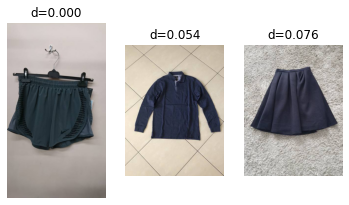

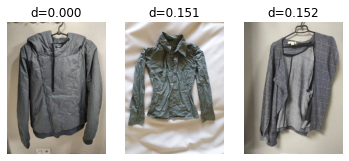

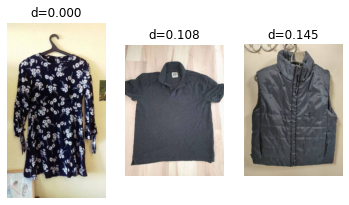

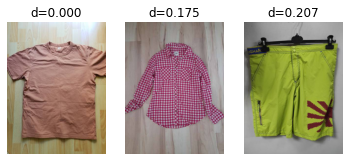

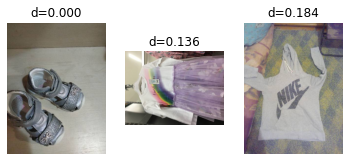

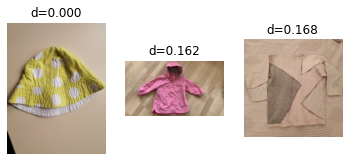

In [ ]:
plot_knn_examples(embeddings)

In [ ]:
new_collate_fn = lightly.data.SimCLRCollateFunction(
    input_size=input_size,
    vf_prob=0.5,
    rr_prob=0.5,
    cj_prob=0.0,
    random_gray_scale=0.0
)

# let's update our collate method and reuse our dataloader
dataloader_train_simclr.collate_fn=new_collate_fn

# create a ResNet backbone and remove the classification head
resnet = torchvision.models.resnet18()
last_conv_channels = list(resnet.children())[-1].in_features
backbone = nn.Sequential(
    *list(resnet.children())[:-1],
    nn.Conv2d(last_conv_channels, num_ftrs, 1),
)
model = lightly.models.SimCLR(backbone, num_ftrs=num_ftrs)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
encoder = lightly.embedding.SelfSupervisedEmbedding(
    model,
    criterion,
    optimizer,
    dataloader_train_simclr
)

encoder.train_embedding(gpus=gpus,
                        progress_bar_refresh_rate=100,
                        max_epochs=max_epochs)
encoder = encoder.to(device)

embeddings, _, fnames = encoder.embed(dataloader_test, device=device)
embeddings = normalize(embeddings)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | SimCLR     | 11.2 M
1 | criterion | NTXentLoss | 0     
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.793    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))

Compute efficiency: 0.04: 100%|██████████| 23/23 [00:22<00:00,  1.00it/s]


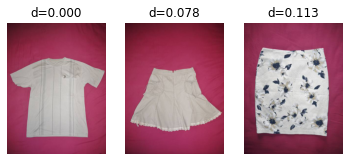

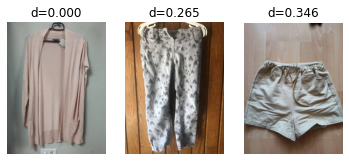

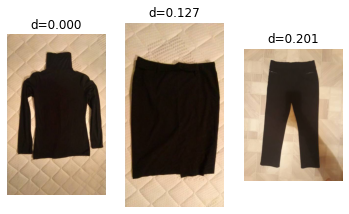

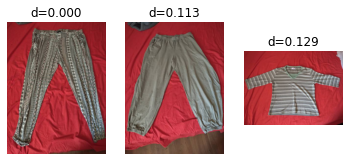

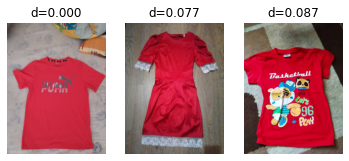

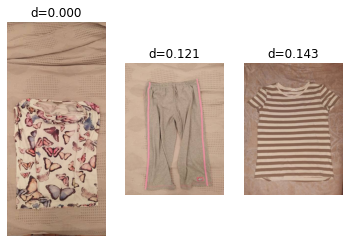

In [ ]:
plot_knn_examples(embeddings)